### Quick play with the entropy loss calculation
As per Mark Gales's suggestion, I need to try optimizing for entropy rather than cross-entropy

In [3]:
# needs to run in the fader-networks branch
# (that's also where all the checkpoints are)
import os
os.chdir('/home/ubuntu/msc-project-fader-networks/')

import notebook_utils as nu

In [4]:
import sys
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

from model import Loop, MaskedMSE

from utils import generate_merlin_wav

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from IPython.display import Audio
import IPython.display

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [7]:
import training_monitor as tm
import model_discriminator as md

In [8]:
os.getcwd()

'/home/ubuntu/msc-project-fader-networks'

In [69]:
checkpoint = 'checkpoints/fader_gender_concat_lambda50_20180719/epoch_10.pth'
discriminator_checkpoint = 'checkpoints/fader_gender_concat_lambda50_20180719/discriminator_epoch_10.pth'

In [6]:
checkpoint = 'checkpoints/fader_gender_concat_lambda50_20180720/epoch_20.pth'
discriminator_checkpoint = 'checkpoints/fader_gender_concat_lambda50_20180720/discriminator_epoch_20.pth'

In [233]:
checkpoint = 'checkpoints/fader_gender_add_20180720_test/epoch_163.pth'
discriminator_checkpoint = 'checkpoints/fader_gender_add_20180720_test/discriminator_epoch_163.pth'

In [309]:
checkpoint = 'checkpoints/fader_gender_concat_baseline163_20180720/epoch_181.pth'
discriminator_checkpoint = 'checkpoints/fader_gender_concat_baseline163_20180720/discriminator_epoch_181.pth'

In [155]:
checkpoint = 'checkpoints/fader_gender_add_baseline163_20180722/epoch_167.pth'
discriminator_checkpoint = 'checkpoints/fader_gender_add_baseline163_20180722/discriminator_epoch_167.pth'

In [247]:
checkpoint = 'checkpoints/fader_gender_add_baseline163_500_20180722/epoch_191.pth'
discriminator_checkpoint = 'checkpoints/fader_gender_add_baseline163_500_20180722/discriminator_epoch_191.pth'

In [336]:
checkpoint = 'checkpoints/fader_gender_concat_from_scratch_nodisc_20180724/epoch_9.pth'
discriminator_checkpoint = 'checkpoints/fader_gender_concat_from_scratch_nodisc_20180724/discriminator_epoch_9.pth'

In [47]:
#checkpoint = 'checkpoints/fader_recreate_baseline_20180719_debug/epoch_6.pth'
#discriminator_checkpoint = 'checkpoints/fader_recreate_baseline_20180719_debug/discriminator_epoch_6.pth'

In [337]:
start_epoch = 1

checkpoint_args_path = os.path.dirname(checkpoint) + '/args.pth'
checkpoint_args = torch.load(checkpoint_args_path)

In [338]:
#checkpoint_args[0].speaker_hidden_size = 256

In [339]:
checkpoint_args[0].speaker_hidden_size

254

In [340]:
start_epoch = checkpoint_args[3]
model = Loop(checkpoint_args[0])
model.cuda()

In [341]:
model.encoder.lut_s

Embedding(107, 254, max_norm=1.0)

In [342]:
model.load_state_dict(torch.load(checkpoint, map_location=lambda storage, loc: storage))

In [316]:
t = torch.load(checkpoint, map_location=lambda storage, loc: storage)

In [183]:
t = torch.load('/home/ubuntu/msc-project-master/msc-project-master/checkpoints/vctk-all-2-v2/args.pth', map_location=lambda storage, loc: storage)

In [57]:
t[0].noise

KeyError: 0

In [241]:
t['encoder.lut_s.weight'] = t['encoder.lut_s.weight'][:, :-2]

In [217]:
t['encoder.lut_s.weight'] 


 9.1777e-02 -4.8963e-02 -2.1828e-02  ...   1.2975e-02  3.6994e-02  1.6140e-02
 3.0983e-02  7.0526e-02  5.4640e-02  ...  -1.5276e-01 -7.7704e-02 -4.4520e-03
-1.2949e-03  4.8820e-02  2.5005e-02  ...  -3.2970e-02  9.1233e-02  1.4013e-01
                ...                   ⋱                   ...                
-3.4317e-02 -3.2025e-02 -8.3225e-02  ...  -7.7593e-02  2.2665e-02 -8.4483e-02
 9.2621e-03 -7.6265e-02  1.1671e-02  ...   1.2961e-02 -2.3637e-02  7.7924e-02
 3.4034e-02 -2.0539e-02 -1.3309e-01  ...   2.4829e-02  3.3400e-02 -3.6276e-02
[torch.FloatTensor of size 107x252]

In [136]:
m =  nn.Embedding(2, 256, max_norm=1.0)
type(m)

torch.nn.modules.sparse.Embedding

In [142]:
type( nn.Embedding(2, 256, max_norm=1.0).weight.data)

torch.FloatTensor

In [343]:
criterion = MaskedMSE().cuda()
#optimizer = optim.Adam(model.parameters(), lr=args.lr)

speaker_info = md.get_speaker_info_for_discriminator()

In [344]:
discriminator = md.LatentDiscriminator(checkpoint_args[0].speaker_hidden_size)
discriminator.cuda()
discriminator_criterion = nn.CrossEntropyLoss().cuda()
#discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)
discriminator_criterion_ent = md.HLoss()
discriminator.load_state_dict(torch.load(discriminator_checkpoint, map_location=lambda storage, loc: storage))

In [345]:
embeddings = model.encoder.lut_s.weight.cpu().data.numpy()

In [346]:
train_data, valid_data = md.get_train_valid_split(embeddings, speaker_info)

In [347]:
disc_accuracy = md.eval_discriminator_accuracy(discriminator, train_data, discriminator_criterion)

In [348]:
disc_accuracy

1.0

In [349]:
discriminator.fc1.weight.max()

Variable containing:
 24.8354
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [324]:
embeddings_torch = model.encoder.lut_s.weight
train_data, valid_data = md.get_train_valid_split(embeddings_torch, speaker_info)
md.eval_discriminator(discriminator, train_data, discriminator_criterion_ent)

Variable containing:
 0.6931
[torch.cuda.FloatTensor of size 1 (GPU 0)]

<Container object of 107 artists>

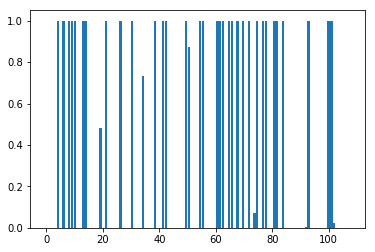

In [262]:
plt.bar(np.linspace(0,107,107), F.softmax(discriminator(train_data[0]), dim=1).data.cpu().numpy()[:,0])
#plt.bar(np.linspace(0,107,107), F.softmax(discriminator(train_data[0]), dim=1).data.cpu().numpy()[:,1])

In [89]:
F.softmax(discriminator(train_data[0]), dim=1)

Variable containing:
 1.0000  0.0000
 0.0000  1.0000
 0.0000  1.0000
 1.0000  0.0000
 1.0000  0.0000
 1.0000  0.0000
 1.0000  0.0000
 0.0000  1.0000
 1.0000  0.0000
 1.0000  0.0000
 1.0000  0.0000
 0.0000  1.0000
 1.0000  0.0000
 1.0000  0.0000
 1.0000  0.0000
 0.0000  1.0000
 0.0000  1.0000
 1.0000  0.0000
 0.0000  1.0000
 0.0000  1.0000
 0.0000  1.0000
 1.0000  0.0000
 1.0000  0.0000
 1.0000  0.0000
 0.0000  1.0000
 0.0000  1.0000
 1.0000  0.0000
 0.0000  1.0000
 0.0000  1.0000
 0.0000  1.0000
 1.0000  0.0000
 0.0000  1.0000
 0.0000  1.0000
 0.0000  1.0000
 1.0000  0.0000
 1.0000  0.0000
 0.0000  1.0000
 1.0000  0.0000
 1.0000  0.0000
 1.0000  0.0000
 1.0000  0.0000
 1.0000  0.0000
 1.0000  0.0000
 0.0000  1.0000
 0.0000  1.0000
 0.0000  1.0000
 0.0000  1.0000
 0.0000  1.0000
 0.0000  1.0000
 1.0000  0.0000
 1.0000  0.0000
 0.0000  1.0000
 0.0000  1.0000
 0.0000  1.0000
 1.0000  0.0000
 1.0000  0.0000
 0.0000  1.0000
 0.0000  1.0000
 0.0000  1.0000
 0.0000  1.0000
 1.0000  0.0000
 0.

In [325]:
discriminator2 = md.LatentDiscriminator(checkpoint_args[0].speaker_hidden_size)
discriminator2.cuda()
discriminator2_criterion = nn.CrossEntropyLoss().cuda()
optimizer2 = optim.Adam(discriminator2.parameters(), lr=0.001)
embeddings = model.encoder.lut_s.weight.cpu().data.numpy()
train_data, valid_data = md.get_train_valid_split(embeddings, speaker_info)
md.train_discriminator(discriminator2, train_data, valid_data, discriminator2_criterion, optimizer2, num_epochs=50)
disc2_accuracy = md.eval_discriminator_accuracy(discriminator2, train_data, discriminator_criterion)
print disc2_accuracy

Discriminator: loss 0.709010, train 0.430 / validation 0.430
0.429906542056


In [169]:
e = np.load('train_embeddings_last.npy')

In [170]:
embeddings = e[0]

In [263]:
embeddings.shape

(107, 256)

In [350]:
# PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(embeddings)

# t-sne
tsne = TSNE(n_components=2)
tsne_fit = tsne.fit_transform(embeddings)

In [351]:
pca.explained_variance_ratio_

array([ 0.02390664,  0.02272321], dtype=float32)

In [352]:
idx_m = speaker_info['gender'] == 'M'
idx_f = speaker_info['gender'] == 'F'

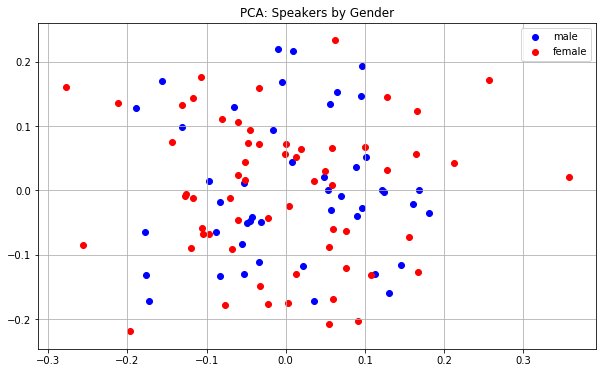

In [353]:
plt.figure(figsize=(10,6))
m_plot = plt.scatter(pca_fit[idx_m, 0], pca_fit[idx_m, 1], c='b', label='male')
f_plot = plt.scatter(pca_fit[idx_f, 0], pca_fit[idx_f, 1], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('PCA: Speakers by Gender')
plt.show()

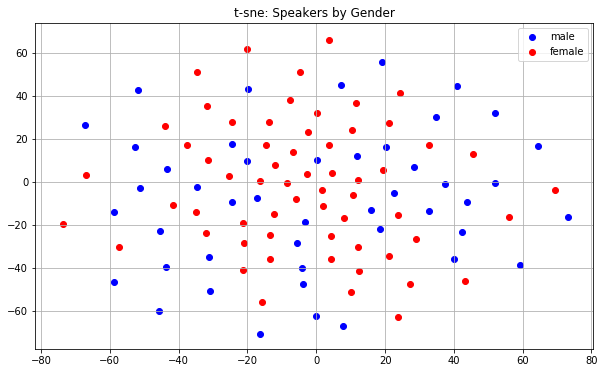

In [354]:
plt.figure(figsize=(10,6))
m_plot = plt.scatter(tsne_fit[idx_m, 0], tsne_fit[idx_m, 1], c='b', label='male')
f_plot = plt.scatter(tsne_fit[idx_f, 0], tsne_fit[idx_f, 1], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('t-sne: Speakers by Gender')
plt.show()

In [355]:
class HLoss(nn.Module):
    def __init__(self):
        super(HLoss, self).__init__()

    def forward(self, x, y=None):
        b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
        b = -1.0 * b.sum(dim=1).mean()
        return b


In [377]:
-(F.softmax(discriminator(train_data[0]), dim=1) * F.log_softmax(discriminator(train_data[0]), dim=1)).sum(dim=1).mean()

Variable containing:
 0.6927
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [392]:
np.random.random(1)

array([ 0.51918607])

In [393]:
x = np.ones_like(x)
x[:, 1]=0
x[:, 0]=1e1
x = np.ones_like(x) * 0.5
#x = np.zeros_like(x)
x

array([[ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5]])

In [347]:
ent = HLoss()

In [218]:
ent(Variable(torch.from_numpy(x))).data[0]

0.6931471805599454

In [202]:
n_runs = 1000
tmp = np.zeros(n_runs)
for i in range(n_runs):
    x = np.random.rand(10,2)
    tmp[i] = ent(Variable(torch.from_numpy(x))).data[0]

In [203]:
tmp.max()

0.69027112108034372

In [196]:
np.log(2)

0.69314718055994529

In [298]:
def gen_gender_swap():
    
    gender_orig = idx_m[spkr_id].astype(float)

    gender_swap = 1 - gender_orig
        
    loop_dict = nu.generate_sample_with_loop(spkr_id=spkr_id, 
                                      npz=npz, 
                                      text=text, 
                                        gender=gender_orig,
                                      checkpoint=checkpoint, 
                                      output_dir ='./',
                                      npz_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features')
    #if not gender_swap:
    if 'output_orig_fname' in loop_dict:
        IPython.display.display(Audio(loop_dict['output_orig_fname'] + '.wav', autoplay=True))
        
    IPython.display.display(Audio(loop_dict['output_file'] + '.wav', autoplay=False))
    
    
    loop_dict = nu.generate_sample_with_loop(spkr_id=spkr_id, 
                                      npz=npz, 
                                      text=text, 
                                        gender=gender_swap,
                                      checkpoint=checkpoint, 
                                      output_dir ='./',
                                      npz_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features')
    IPython.display.display(Audio(loop_dict['output_file'] + '.wav', autoplay=False))

In [373]:
# generate the sample
spkr_id = 33
sentence_id = 307
# (33, 196, 201, 209)
# (34, 217)
# (45, 295)
# (55, 307)
#spkr_id, sentence_id = (34, 217)
spkr_id, sentence_id = (45, 295)
spkr_id, sentence_id = (88, 105)
spkr_id, sentence_id = (99, 115)
spkr_id, sentence_id = (6, 104)
spkr_id, sentence_id = (26, 104)
spkr_id, sentence_id = (29, 104)
spkr_id, sentence_id = (29, 104)
spkr_id, sentence_id = (77, 250)
#spkr_id, sentence_id = (88, 150)
#spkr_id, sentence_id = (89, 150)
#spkr_id, sentence_id = (90, 150)
#spkr_id, sentence_id = (91, 150)
#spkr_id, sentence_id = (92, 150)
#spkr_id, sentence_id = (94, 155) # long 'disaster'
#spkr_id, sentence_id = (95, 155)
#spkr_id, sentence_id = (96, 160)
#text = 'The threats would be a major escalation of the dispute and sparked further falls on stock markets.'
text = 'China responded by accusing the US of blackmail'
text = 'How trying to stay cool could make the world even hotter'
text = "The question on the lips of every England fan"
text = 'either a tomato or a schedule in progress'
npz = "p%d_%d.npz" % (speaker_info.loc[spkr_id].id, sentence_id)

#npz = ''

speaker_info[spkr_id:spkr_id+1]

,id,age,gender,accents,region
77,310,21,F,American,Tennessee


In [374]:
npz_path='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features'
gender = np.array(0).reshape(-1)
output_dir='./'
norm_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/norm_info/norm.dat'

txt, feat, pre_calc_feat = nu.npy_loader_phonemes(os.path.join(npz_path, npz))

txt = Variable(txt.unsqueeze(1), volatile=True)
feat = Variable(feat.unsqueeze(1), volatile=True)
spkr = Variable(torch.LongTensor([spkr_id]), volatile=True)

output_file = os.path.basename(npz)[:-4] + '_' + str(spkr_id)

txt = txt.cuda()
feat = feat.cuda()
spkr = spkr.cuda()
model.train() #! teacher forcing
model.noise=0 #! no noise
#model.eval()
loop_feat, attn = model([txt, spkr, gender], feat)

loop_feat, attn = nu.trim_pred(loop_feat, attn)        
        
generate_merlin_wav(loop_feat.data.cpu().numpy(),
                        output_dir,
                        output_file,
                        norm_path)

complete p310_250_77.wav.


In [371]:
IPython.display.display(Audio(output_file + '.wav', autoplay=True))

In [335]:
IPython.display.display(Audio(output_file + '.wav', autoplay=True))

In [300]:
IPython.display.display(Audio(output_file + '.wav', autoplay=True))